Scrape Data from Craiglist Housing with Selenium and BeautifulSoup

In [137]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

from datetime import datetime
import math
import re


In [138]:
#Helper Function
def substring_after(s, delim):
    return s.partition(delim)[2]

In [139]:
class CraiglistScraper(object):
    def __init__(self, url):
        self.url = url
        self.driver = webdriver.Firefox()
        self.driver.get(self.url)
        self.delay = 3

    def test(self):
        print(self.url)

    def print_total(self): 
        # Help getting the total number of available postings 
        str = self.driver.find_element(By.CLASS_NAME,"cl-page-number").text
        total_pages = int( substring_after(str, " of").replace(' ','').replace(',',''))
        return total_pages

    def load_craiglist_url(self):
        self.driver.get(self.url)
        try:
            wait = WebDriverWait(self.driver, self.delay)
            wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "cl-search-result")))
            print("Page is ready")
        except TimeoutException:
            print("Time out!")

    def extract_post_info(self):
        dates, titles, cities, bdrs, sqfts, prices = ( [] for i in range(6))
        all_posts = self.driver.find_elements(By.CLASS_NAME,"cl-search-result") 
        for post in all_posts:
            content = post.text.split("·")
            if len(content) == 5:
                title = content[0]
                address = content[1]
                date_str = content[2]
                if re.search("[0-9]+-[0-9]+",date_str):
                    date_str = date_str.split("-")
                    month = int(date_str[0])
                    day = int(date_str[1])
                    currentYear = datetime.now().year
                    date = datetime.date(datetime(currentYear, month, day))
                else:
                    date = datetime.date(datetime.now())
                
                area = content[3].strip().split("br")

                if len(area) == 2:
                    bdr = float(area[0])
                    sqft = float(area[1].strip().replace('ft2','')) if len(area[1]) != 0 else None
                else:
                    if area[0].find("ft")>0:
                        sqft = float(area[0].strip().replace('ft2',''))
                        bdr= None
                    else:
                        bdr = area[0]
                        sqft = None
                
                #edge case: Studio
                if (bdr == None and str(title).lower().find('studio') >=0) or (bdr == None and str(title).lower().find('bachelor') >=0):
                    bdr = 1

                price = re.findall(r'\$\d+(?:\,\d+)?', content[4])[0]
                price = float(str(price).strip().replace('$','').replace(',','')) 

                titles.append(title)
                cities.append(address)
                dates.append(date)
                bdrs.append(bdr)
                sqfts.append(sqft)
                prices.append(price)
            
            elif len(content) == 4:
                print(post.text)
                title = content[0]
                address = content[1]
                date = content[2]
                print("before",date)
                bdr, sqft = None, None

                date_str = content[2]
                if re.search("[0-9]+-[0-9]+",date_str):
                    date_str = date_str.split("-")
                    month = int(date_str[0])
                    day = int(date_str[1])
                    currentYear = datetime.now().year
                    date = datetime.date(datetime(currentYear, month, day))
                else:
                    date = datetime.date(datetime.now())

                try:
                    price = re.findall(r'\$\d+(?:\,\d+)?', content[3])[0]
                    price = float(str(price).strip().replace('$','').replace(',','')) 
                except:
                    price= None

                 #edge case for Studio
                if (bdr == None and str(title).lower().find('studio') >=0) or (bdr == None and str(title).lower().find('bachelor') >=0):
                    bdr = 1

                print('after',date)
                titles.append(title)
                cities.append(address)
                dates.append(date)
                bdrs.append(bdr)
                sqfts.append(sqft)
                prices.append(price)
                
            else:
                print("WARNING_____"  )
                print(content)
                post_content = ','.join(content)
                titles.append(post_content)
                cities.append(None)
                dates.append(None)
                bdrs.append(None)
                sqfts.append(None)
                prices.append(None)

        return titles,cities,prices,dates,bdrs,sqfts

    def extract_post_url(self):
        url_list =[]
        content = self.driver.page_source.encode('utf-8').strip()
        soup = BeautifulSoup(content,"html.parser")
        for link in soup.findAll("a", {"class":"titlestring"}):
            url_list.append(link["href"])
        return url_list
    
    def quit(self):
        self.driver.close()



In [140]:
vancouver_area = ['bnc','rds','nvn','rch','pml','van']
toronto_area = ['bra','tor','drh','mss','oak','yrk']
other_areas =['victoria','winnipeg','abbotsford', 'calgary', 'edmonton', 'halifax', 'hamilton','kitchener','ottawa']

areas = [vancouver_area , toronto_area , other_areas]
print(areas)

post_titles, post_area, post_address, post_price, post_dates, post_brs, post_sqft, post_urls = ([] for i in range(8))

for area in areas:
    for city in area:
        total_page = 10000
        start = 0
        while start < total_page:
            if area == vancouver_area:
                base_url = f"https://vancouver.craigslist.org/search/{city}/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~{start}~0"
            elif area == toronto_area:
                base_url = f"https://toronto.craigslist.org/search/{city}/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~{start}~0"
            else:
                base_url = f"https://{city}.craigslist.org/search/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~{start}~0"
            
            scraper = CraiglistScraper(base_url)
            scraper.test()
            scraper.load_craiglist_url()
            
            if total_page == 10000: 
                total_page = math.ceil(scraper.print_total()/120)
                print("Total page :")    
                print(total_page)
                
            info = scraper.extract_post_info()
            post_titles += info[0]
            post_address += info[1]
            post_price += info[2]
            post_dates += info[3]
            post_brs += info[4]
            post_sqft += info[5]
            urls = scraper.extract_post_url()
            post_urls += urls
            post_area += [city]*len(urls)
            
            start+= 1
            scraper.quit()

[['bnc', 'rds', 'nvn', 'rch', 'pml', 'van'], ['bra', 'tor', 'drh', 'mss', 'oak', 'yrk'], ['victoria', 'winnipeg', 'abbotsford', 'calgary', 'edmonton', 'halifax', 'hamilton', 'kitchener', 'ottawa']]
https://vancouver.craigslist.org/search/bnc/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~0~0
Page is ready
Total page :
5
2 Bedroom Penthouse -Royal City Center·New Westminster·05-25·$2,900pic
before 05-25
after 2023-05-25
https://vancouver.craigslist.org/search/bnc/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~1~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~2~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~3~0
Page is ready
https://vancouver.craigslist.org/search/bnc/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~4~0
Page is ready
https://vancouver.craigslist.org/search/rds/apa?hasPic=1&housing_type=1&housing_type=2#sear

In [141]:
import pandas
import emoji

df = pandas.DataFrame(data ={"Title": post_titles , "Area": post_area, "Address": post_address, "Price": post_price, "Date": post_dates,
                              "Number of Bedroom": post_brs, "Square Feet": post_sqft, "URL": post_urls})
df_raw = df.copy()
print(len(df_raw))

df= df.loc[ (df['Number of Bedroom'] == 1) | (df['Number of Bedroom'] == 2) | (df['Number of Bedroom'] == 3) ]
df['Area'] = df['Area'].replace(['bnc','rds','nvn','rch','pml','van'],['Burnaby/Newwest','Delta/Surrey/Langley', 'North Shore' , 'Richmond', 'Tricities/Pitt/Maple','Vancouver'])
df['Area'] = df['Area'].replace(['bra','tor','drh','mss','oak','yrk'],['Brampton', 'City of Toronto', 'Durham Region', 'Mississauga', 'Oakville', 'York Region'])

df['Area'] = df['Area'].str.capitalize()
df = df.drop_duplicates(subset= ['Title','Price','Number of Bedroom','Square Feet'])
df['Square Feet'] = df['Square Feet'].mask(df['Square Feet']>3000) # Convert Square Feet to Nan when its more than 3000
df = df[ df.Title.str.lower().str.contains("rv pad") != True] # "RV Pad" edge cases
df['Title'] = df['Title'].apply(lambda s: emoji.replace_emoji(s, '')) # Remove emojis

print("Number of Postings is ", len(df))

7961
Number of Postings is  7118


In [142]:
#Remove Outliers
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['Price'] < (Q1 - 1.5 * IQR)) |(df['Price'] > (Q3 + 1.5 * IQR)))]
print("Number of Postings is ", len(df))
df.to_csv("./Housing_Craiglist.csv", sep=',',index=False)

Number of Postings is  6600


In [143]:
#Calling the .describe() method to get a more detailed look.
one_br = df.loc[ (df['Number of Bedroom'] == 1) ]
one_br.describe().round(2)

,Price,Number of Bedroom,Square Feet
count,3530.00,3530.0,2746.00
mean,2354.94,1.0,600.27
std,541.94,0.0,126.67
min,700.00,1.0,1.00
25%,1950.00,1.0,526.00
50%,2400.00,1.0,600.00
75%,2650.00,1.0,650.00
max,4650.00,1.0,2100.00


In [144]:
two_br = df.loc[ (df['Number of Bedroom'] == 2) ]
two_br.describe().round(2)

,Price,Number of Bedroom,Square Feet
count,2533.00,2533.0,1953.00
mean,2950.91,2.0,900.35
std,766.41,0.0,195.64
min,750.00,2.0,1.00
25%,2450.00,2.0,800.00
50%,2900.00,2.0,881.00
75%,3500.00,2.0,980.00
max,4700.00,2.0,3000.00


In [145]:
three_br = df.loc[df['Number of Bedroom'] == 3 ]
three_br.describe().round(2)

,Price,Number of Bedroom,Square Feet
count,537.00,537.0,267.00
mean,3200.07,3.0,1276.90
std,808.57,0.0,389.74
min,715.00,3.0,650.00
25%,2750.00,3.0,1007.50
50%,3090.00,3.0,1200.00
75%,3800.00,3.0,1461.00
max,4700.00,3.0,3000.00


<AxesSubplot: xlabel='Number of Bedroom', ylabel='count'>

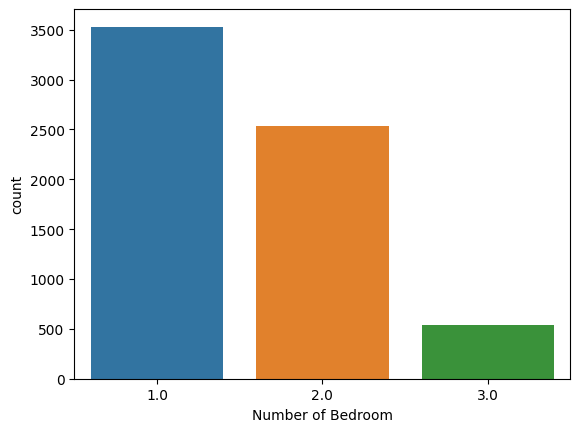

In [146]:
import seaborn as sns
sns.countplot(x = df['Number of Bedroom'])

In [147]:
avg_price = df.groupby(df['Number of Bedroom']).mean().round()
print(avg_price)

                    Price  Square Feet
Number of Bedroom                     
1.0                2355.0        600.0
2.0                2951.0        900.0
3.0                3200.0       1277.0


C:\Users\Tu\AppData\Local\Temp\ipykernel_17532\3848901673.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_price = df.groupby(df['Number of Bedroom']).mean().round()


Text(0.5, 1.0, 'Prices by Areas')

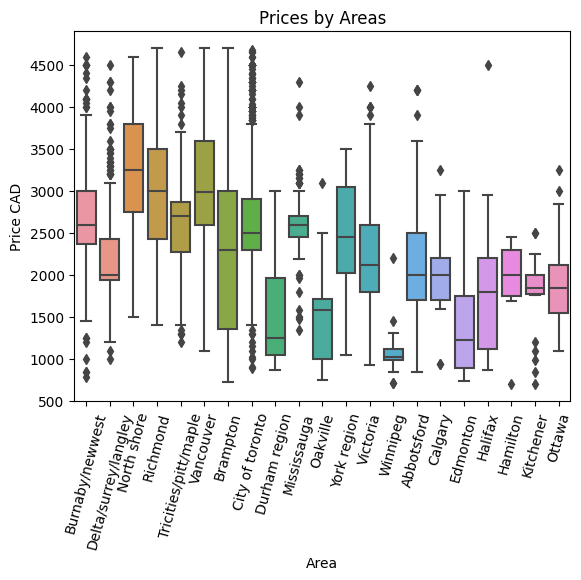

In [148]:
from matplotlib import pyplot as plt

sns.boxplot(x='Area', y='Price', data=df)
plt.xlabel("Area")
plt.xticks(rotation=75)
plt.ylabel("Price CAD")
plt.title("Prices by Areas")

Text(0, 0.5, 'Square Feet')

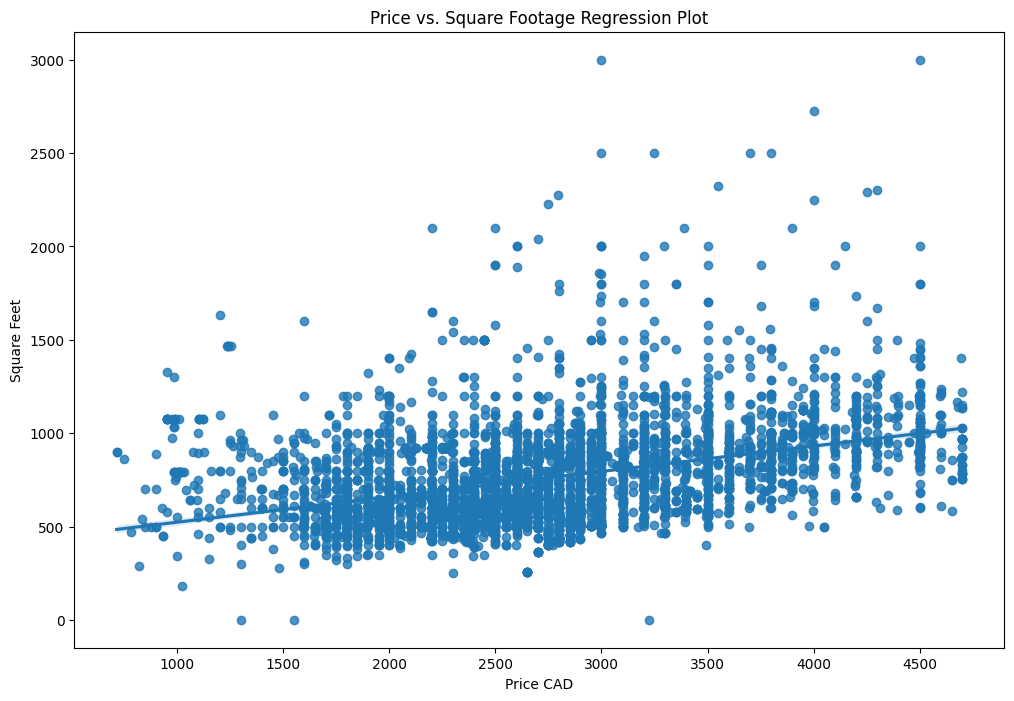

In [149]:

plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Square Feet', data= df.dropna())
plt.title('Price vs. Square Footage Regression Plot')
plt.xlabel("Price CAD")
plt.ylabel("Square Feet")

Step 2. Connect to the MySQL and create a database

In [150]:
import mysql.connector as msql
from mysql.connector import Error

try:
    conn = msql.connect(host="127.0.0.1", port="3306", user="root", password="trinhviettud22", auth_plugin="mysql_native_password")
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("CREATE DATABASE craigslist_housing")
        print("craigslist_housing database is created")
except Error:
        print("Error while connecting to MySQL", Error )


Error while connecting to MySQL <class 'mysql.connector.errors.Error'>


In [151]:
import mysql.connector 
df = df.fillna(0)

try:
    conn = mysql.connector.connect(host="127.0.0.1", database = 'craigslist_housing', port="3306", user="root", password="", auth_plugin="mysql_native_password")
    if conn.is_connected():
        cursor = conn.cursor() #A cursor is an object which helps to execute the query and fetch the records from the database. 
        cursor.execute("select database();")
        record = cursor.fetchone()
        #print("You're connected to database: ", record)
        cursor.execute('DROP TABLE IF EXISTS craigslist_housing.postings')
        #print('Creating table...')
        cursor.execute("CREATE TABLE postings ( Title VARCHAR(500) NOT NULL, Area VARCHAR(100) NOT NULL, Address VARCHAR(500), Price FLOAT(4,0) , Date DATE,Number_of_bedroom ENUM('1.0','2.0','3.0'), Square_Feet FLOAT(4,0), URL VARCHAR(1000) NOT NULL)")
        #print('Table has been created!')
        for i,row in df.iterrows():
            #print(tuple(row))
            sql = 'INSERT INTO craigslist_housing.postings VALUES (%s,%s,%s,%s,%s,%s,%s,%s)'
            cursor.execute(sql, tuple(row))
            print("Record inserted")
            conn.commit()
except mysql.connector.Error as err:
    print("Something went wrong: {}".format(err))

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record i

In [152]:
print(len(df))

6600
